<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/Kaz0Inf-Folder/Kaz0Inf/cvae_conv2d_RGB_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Работа с массивами данных
import numpy as np
# Работа с таблицами
import random
import pandas as pd
# Основные слои
from tensorflow.keras.layers import Dense,UpSampling2D, Dropout, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Lambda, LeakyReLU
# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam
# Функции-утилиты для работы с каегориальными данными
from tensorflow.keras import utils
# Загрузка сохраненной модели
from tensorflow.keras.models import load_model
# класс для использования Functional API
from tensorflow.keras import Model
# Отрисовка изображения
from tensorflow.keras.preprocessing import image
# Импортируем Keras
from tensorflow import keras
# Импортируем Keras
import keras
# Подключим модуль вычислений на Keras
import keras.backend as K
# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 
# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error
# Загрузка датасетов из облака google
import gdown
# Функции операционной системы
import os
# Работа со временем
import time
# Работа с таблицами
import pandas as pd
from PIL import Image
import cv2
# Отрисовка графиков
import matplotlib.pyplot as plt 
import os #
from google.colab import drive #модуль для работы с google диском 
import gdown
import os
from PIL import Image
import re
import time, random
import seaborn as sns
%matplotlib inline
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
IMG_WIDTH = 200
IMG_HEIGHT = 200
CHANELS = 3
num_classes = 13

FILE_DIR  = '/content/drive/MyDrive/selector/dataset'
dir_list = os.listdir(FILE_DIR)
CLASS_LIST = sorted(os.listdir(FILE_DIR))
CLASS_COUNT = len(CLASS_LIST)

image_array = []
data_labels = []
class_label = 0

FILE_DIR  = '/content/drive/MyDrive/selector/dataset'
dir_list = os.listdir(FILE_DIR)
image_array = []

for i in dir_list:
  class_label += 1
  file_list = os.listdir(f'/content/drive/MyDrive/selector/dataset/{i}')
  ch = 0
  dl = len(file_list)
  for image in file_list:
    try:
      img = Image.open(f'/content/drive/MyDrive/selector/dataset/{i}/{image}').resize((IMG_HEIGHT, IMG_WIDTH)).convert("RGB")
      img_np = np.array(img)
      image_array.append(img_np)
      ch += 1
    except:
      print(f'При обработке файла {i}/{image} произошла ошибка')
      pass
  print(f'Каталог {i} обработан, добавлено {ch} изображений из {dl}')
  data_labels += [class_label] * ch

image_array = np.array(image_array)
image_array = image_array.reshape(-1,IMG_HEIGHT,IMG_WIDTH,CHANELS)
image_array = image_array.astype('float32')
image_array /= 255

x_data = image_array
y_data = np.array(data_labels)



x_train, x_test, y_train, y_test = train_test_split(x_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)



Каталог sportswear women обработан, добавлено 100 изображений из 100
Каталог dress  business обработан, добавлено 86 изображений из 86
Каталог t-shirt men обработан, добавлено 100 изображений из 100
Каталог dress homemade обработан, добавлено 100 изображений из 100
Каталог dress solemn обработан, добавлено 100 изображений из 100
Каталог shirt women обработан, добавлено 100 изображений из 100
Каталог t-shirt women обработан, добавлено 100 изображений из 100
Каталог trousers women обработан, добавлено 100 изображений из 100
Каталог shirt men обработан, добавлено 100 изображений из 100
Каталог trousers men обработан, добавлено 100 изображений из 100
Каталог sportswear men обработан, добавлено 100 изображений из 100
Каталог dress casual обработан, добавлено 100 изображений из 100


In [3]:

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(948, 200, 200, 3)
(948,)
(238, 200, 200, 3)
(238,)


In [ ]:
x_train.shape[1:3]

(200, 200)

In [5]:
input_img = Input((200, 200, 3)) 
batch_size = 20
latent_dim = 13

#Энкодер
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img) # входные данные передаем на слой двумерной свёртки
x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
x = BatchNormalization()(x) # и еще слой нормализации данных
x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
x = BatchNormalization()(x) # и еще слой нормализации данных
x = MaxPooling2D()(x) # передаём на слой подвыборки

flatten = Flatten()(x)                                    # Добавим Flatten
lb = Input(shape=(num_classes,))                         # Добавим вход для метки класса
x = concatenate([flatten, lb])                           # Конкатенируем метку класса с выходом flatten
encoded = Dense(latent_dim, activation='relu')(x)    


encoder = Model([input_img, lb], encoded, name='encoder')

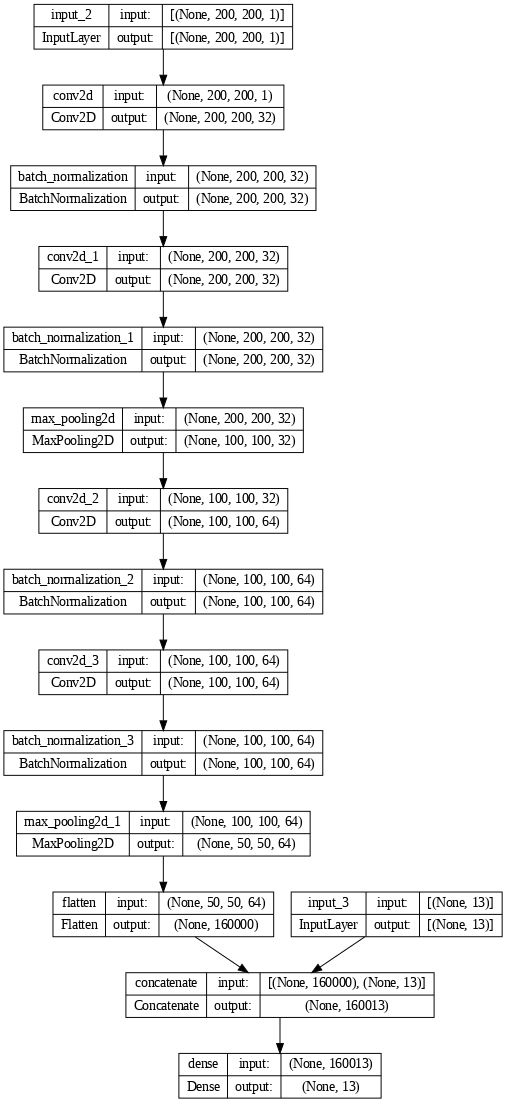

In [ ]:
utils.plot_model(encoder, show_shapes=True, dpi=70)

In [ ]:
encoder.summary()

In [6]:
#Декодер

input_dec = encoded 
lb_dec = Input(shape=(num_classes,))  # Добавим вход для метки класса
z = concatenate([input_dec, lb_dec])
d = Dense(160000, activation='relu')(z)
d = Reshape((50,50,64))(d)
d = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(d)  # слой разжимает данные
d = BatchNormalization()(d)  # слой нормализации данных
d = Conv2D(64, (3, 3), padding='same', activation='relu')(d)  # передаем на слой двумерной свёртки
d = BatchNormalization()(d)  # слой нормализации данных
d = Conv2D(64, (3, 3), padding='same', activation='relu')(d)  # ещё слой двумерной свёртки
d = BatchNormalization()(d)  # слой нормализации данных

d = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(d)  # слой разжимает данные
d = BatchNormalization()(d)  # слой нормализации данных
d = Conv2D(32, (3, 3), padding='same', activation='relu')(d)  # передаем на слой двумерной свёртки
d = BatchNormalization()(d)  # слой нормализации данных
d = Conv2D(32, (3, 3), padding='same', activation='relu')(d)  # ещё слой двумерной свёртки
d = BatchNormalization()(d)  # слой нормализации данны
decoded = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(d)  # выходной слой с сигмоидной функцией активации


In [7]:
decoder = Model([input_dec, lb_dec], decoded, name='decoder')

In [ ]:
decoder.summary()

In [8]:
autoencoder = Model([input_img, lb, lb_dec], decoded, name="autoencoder")

In [ ]:
autoencoder.summary()
utils.plot_model(autoencoder, show_shapes=True, dpi=70)

In [9]:
autoencoder.compile(optimizer='adam', loss='mse') # оптимайзер ADAM


# Обучим модель
autoencoder.fit([x_train, y_train_cat, y_train_cat],  # Обучающая выборка + метки классов для энкодера и декодера
         x_train,                              # Обучающая выборка
         epochs=50,                            # Число эпох
         batch_size=batch_size,                # Размер батча
         shuffle=True)                         # Обучающую выборку перемешиваем

Epoch 1/50
48/48 [==============================] - 30s 190ms/step - loss: 0.0986
Epoch 2/50
48/48 [==============================] - 8s 162ms/step - loss: 0.0498
Epoch 3/50
48/48 [==============================] - 8s 164ms/step - loss: 0.0398
Epoch 4/50
48/48 [==============================] - 8s 164ms/step - loss: 0.0346
Epoch 5/50
48/48 [==============================] - 8s 170ms/step - loss: 0.0305
Epoch 6/50
48/48 [==============================] - 8s 165ms/step - loss: 0.0296
Epoch 7/50
48/48 [==============================] - 8s 167ms/step - loss: 0.0270
Epoch 8/50
48/48 [==============================] - 8s 169ms/step - loss: 0.0269
Epoch 9/50
48/48 [==============================] - 8s 168ms/step - loss: 0.0254
Epoch 10/50
48/48 [==============================] - 8s 170ms/step - loss: 0.0250
Epoch 11/50
48/48 [==============================] - 8s 170ms/step - loss: 0.0258
Epoch 12/50
48/48 [==============================] - 8s 172ms/step - loss: 0.0244
Epoch 13/50
48/48 [=====

In [10]:
images = x_train
lb = lb_dec = y_train_cat
codes = encoder.predict([x_train, lb], batch_size=batch_size)

assert len(codes) == len(images)

from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)


48/48 [==============================] - 1s 16ms/step


NearestNeighbors(metric='euclidean')

In [11]:
def get_similar(image, lb2, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = code = encoder.predict([image[None], lb2[None]], batch_size=batch_size)  
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    return distances,images[idx]
def show_similar(num_img):
    image = x_train[num_img]
    lb2 = lb[num_img]
    distances,neighbors = get_similar(image, lb2, n_neighbors=12)
    plt.figure(figsize=[16,14])
    plt.subplot(1,4,1)
    plt.imshow(image, cmap='gray')
    plt.title("Выбранное изображение")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.imshow(neighbors[i], cmap='gray')
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

1/1 [==============================] - 0s 27ms/step


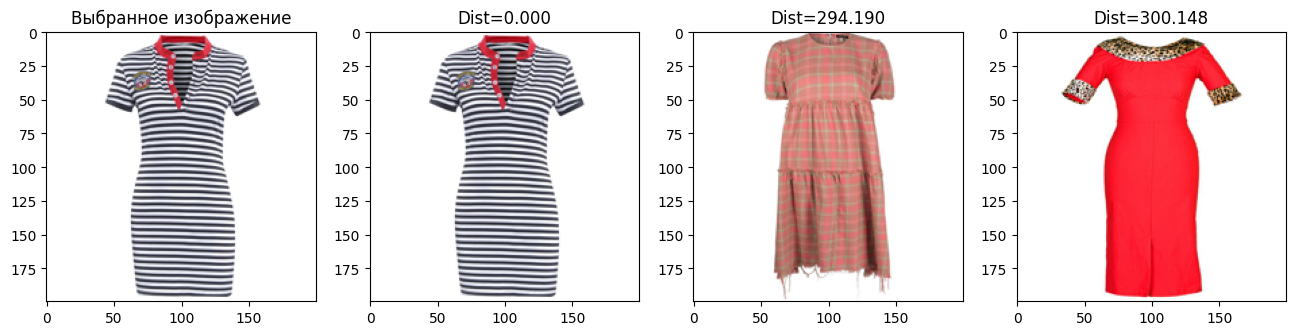

1/1 [==============================] - 0s 22ms/step


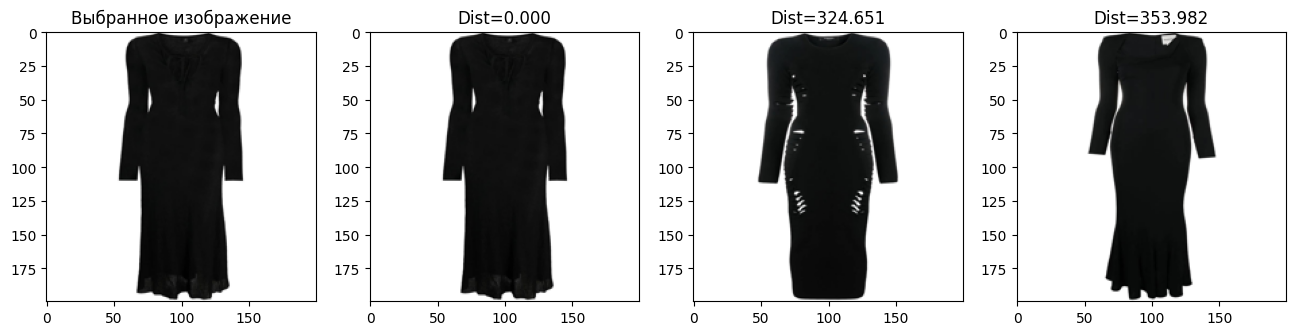

1/1 [==============================] - 0s 24ms/step


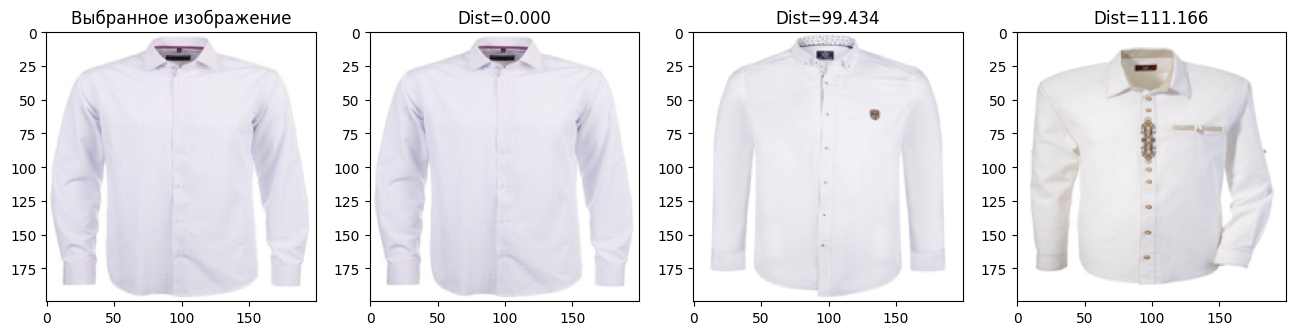

1/1 [==============================] - 0s 30ms/step


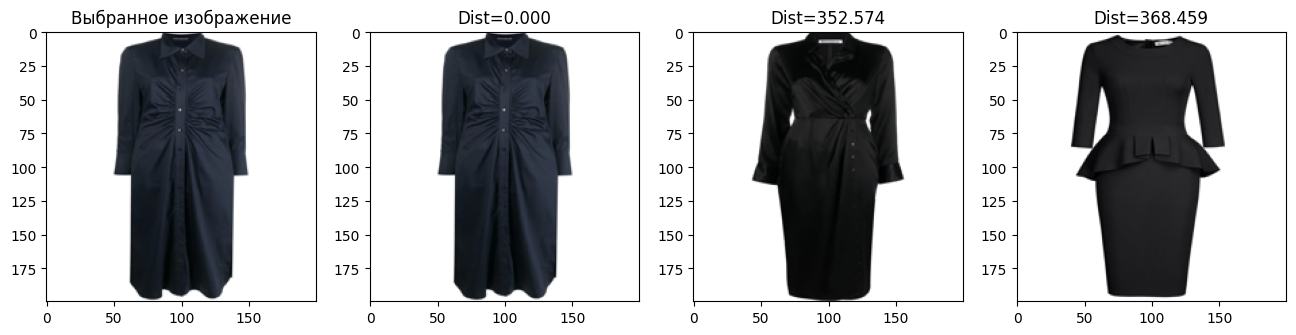

1/1 [==============================] - 0s 22ms/step


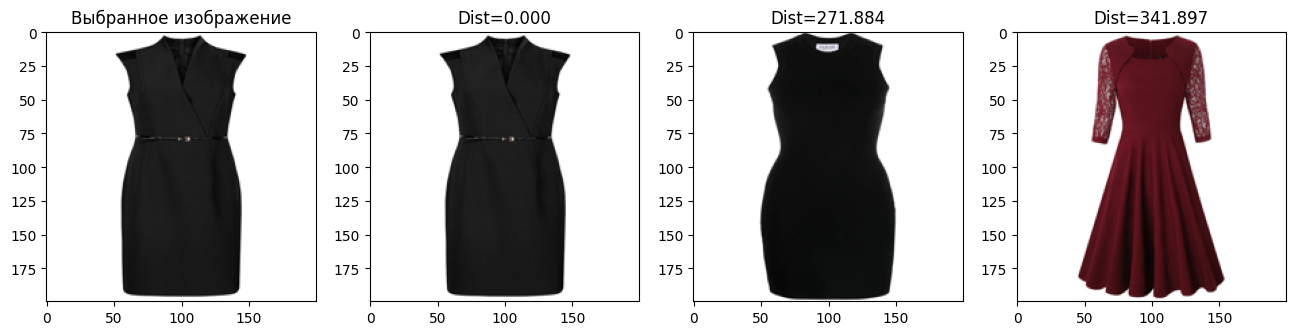

1/1 [==============================] - 0s 20ms/step


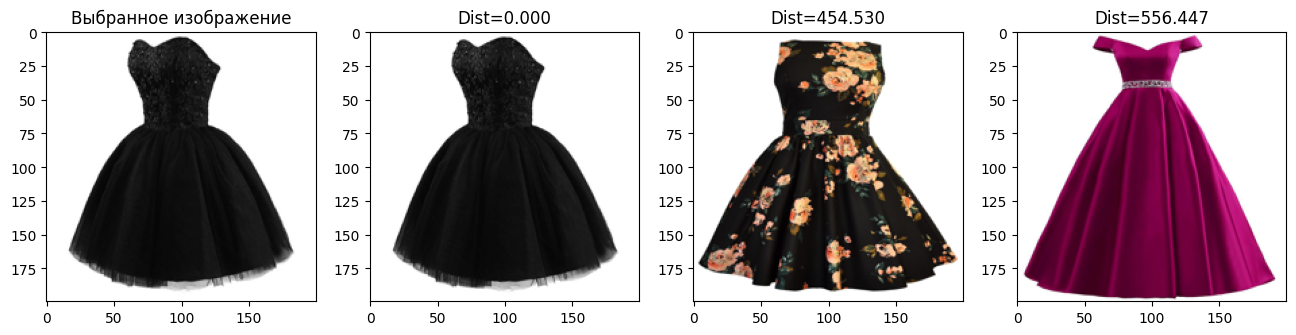

1/1 [==============================] - 0s 27ms/step


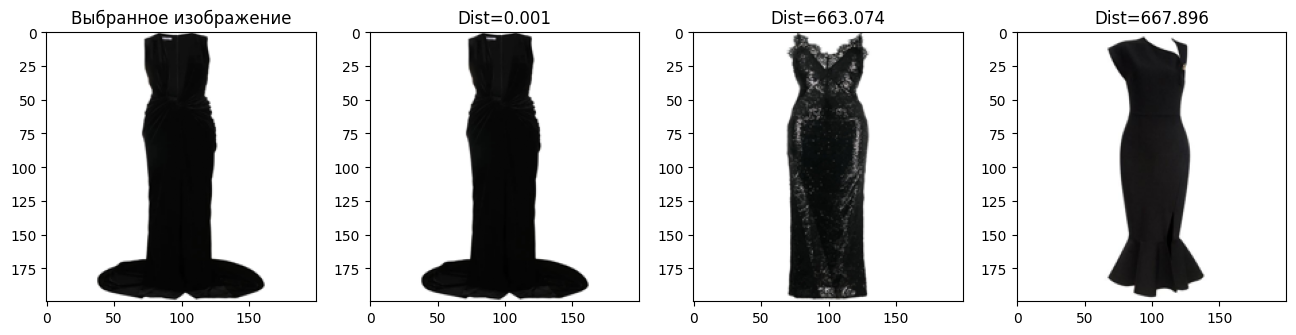

1/1 [==============================] - 0s 34ms/step


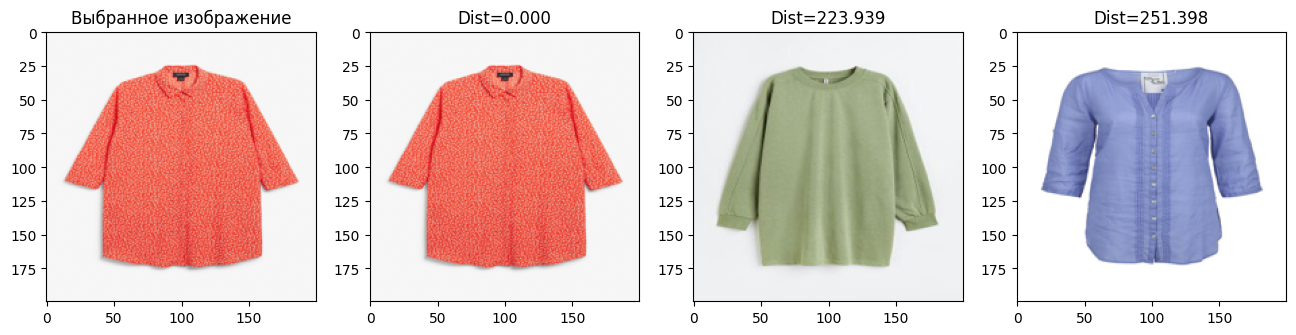

1/1 [==============================] - 0s 40ms/step


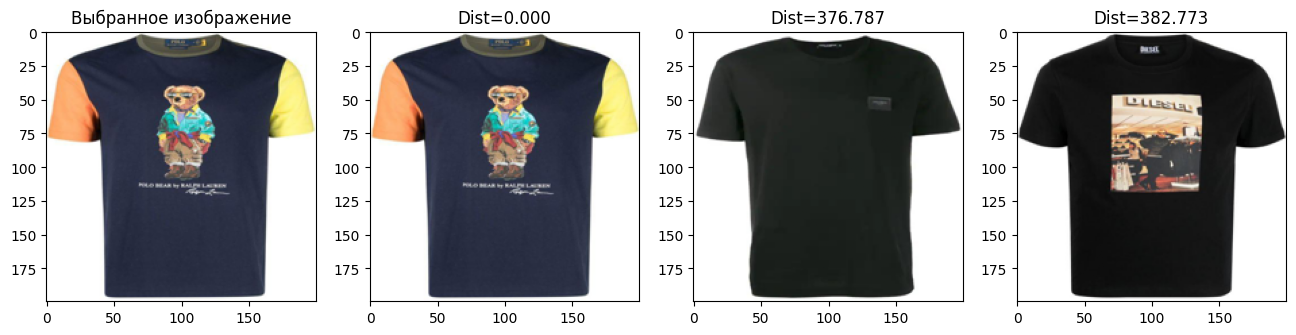

1/1 [==============================] - 0s 39ms/step


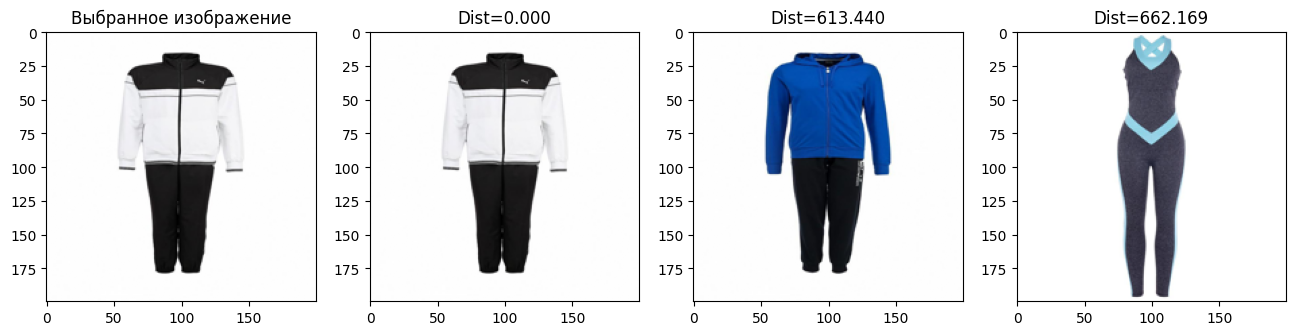

In [14]:
show_similar(3)
show_similar(53)
show_similar(103)
show_similar(153)
show_similar(203)
show_similar(253)
show_similar(303)
show_similar(353)
show_similar(403)
show_similar(453)